In [1]:
import random
import torch
from torch import nn

import triton

from egs.baselines import TorchEinsumGather, TorchLinearGather, TorchEinsumScatter
from egs import ExpertGather, ExpertScatter

def is_cuda():
    return triton.runtime.driver.active.get_current_target().backend == "cuda"
ref_lib = 'cuBLAS' if is_cuda() else 'rocBLAS'


seed = 42

random.seed(seed)
torch.manual_seed(seed)

In [2]:
def gather_benchmark_speed(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    X = torch.randn((B, T, I), device=DEVICE, dtype=torch.float32, requires_grad=True)
    W = torch.randn((E, I, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertGather(E, I, J).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumGather(E, I, J).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    if provider == 'torch':
        def run():
            Y_torch = torch_einsum_head_projection(X, Ind64)
            l = Y_torch.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            Y_esg = kernel_head_projection(X, Ind)
            l = Y_esg.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")

    return ms, max_ms, min_ms

def gather_benchmark_memory(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda" 
    
    X = torch.randn((B, T, I), device=DEVICE, dtype=torch.float32, requires_grad=True)
    W = torch.randn((E, I, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertGather(E, I, J).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumGather(E, I, J).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)
    torch.cuda.reset_peak_memory_stats()
    if provider == 'torch':
        def run():
            Y_torch = torch_einsum_head_projection(X, Ind64)
            l = Y_torch.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            Y_esg = kernel_head_projection(X, Ind)
            l = Y_esg.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)

    return memory_used, memory_used, memory_used

def scatter_benchmark_speed(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    Y = torch.randn((B, E, K, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertScatter(E, J, I).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumScatter(E, J, I).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    if provider == 'torch':
        def run():
            X_torch = torch_einsum_head_projection(Y, Ind64, T)
            l = X_torch.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            X_esg = kernel_head_projection(Y, Ind, T)
            l = X_esg.sum()
            l.backward()
        ms, min_ms, max_ms = triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    
    return ms, max_ms, min_ms
    
def scatter_benchmark_memory(T, B, E, J, I, K, provider, fp8_inputs):
    quantiles = [0.5, 0.2, 0.8]

    DEVICE = "cuda"  
    
    Y = torch.randn((B, E, K, J), device=DEVICE, dtype=torch.float32, requires_grad=True)
    kernel_head_projection = ExpertScatter(E, J, I).to(DEVICE)

    torch_einsum_head_projection = TorchEinsumScatter(E, J, I).to(DEVICE)
    torch_einsum_head_projection.W = nn.Parameter(kernel_head_projection.W)

    Ind = torch.randint(0, T-1, (B, E, K), device=DEVICE, dtype=torch.int16, requires_grad=False)
    Ind64 = Ind.to(torch.int64)

    torch.cuda.reset_peak_memory_stats()
    if provider == 'torch':
        def run():
            X_torch = torch_einsum_head_projection(Y, Ind64, T)
            l = X_torch.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    elif provider == "egs":
        def run():
            X_esg = kernel_head_projection(Y, Ind, T)
            l = X_esg.sum()
            l.backward()
        triton.testing.do_bench(run, quantiles=quantiles)
    else:
        raise ValueError(f"Unknown provider: {provider}")
    memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)

    return memory_used, memory_used, memory_used

In [9]:
# Default config
E = 32 # Number of experts
T = 128 # Sequence length
K = 32 # Number of tokens to process by each expert
B = 64 # Batch size
J = 64 # Number of dimensions for the output of gather and input of scatter
I = 128 # Number of dimensions for the input of gather and output of scatter

# Scaling with T 

ratio T / K is important for the performance benefits. For sparse gathers egs avoids unnecessarily computed large matrices.

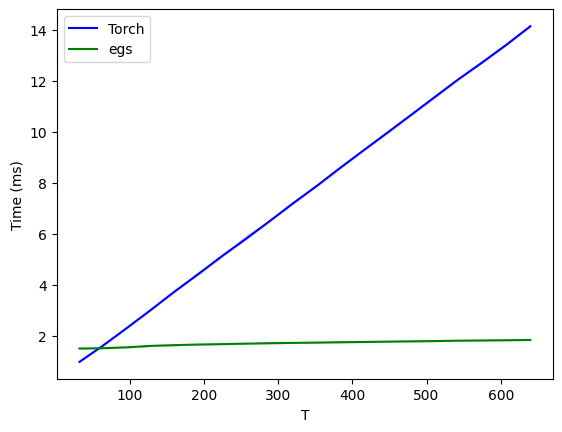

time needed for a forward and a backward pass:
        T      Torch       egs
0    32.0   0.967600  1.491584
1    64.0   1.612800  1.505280
2    96.0   2.300416  1.539072
3   128.0   3.002368  1.595392
4   160.0   3.723264  1.624992
5   192.0   4.410368  1.648640
6   224.0   5.117952  1.665120
7   256.0   5.788928  1.683456
8   288.0   6.484848  1.701888
9   320.0   7.193600  1.713152
10  352.0   7.879488  1.724992
11  384.0   8.598160  1.739776
12  416.0   9.294336  1.749152
13  448.0   9.988096  1.763328
14  480.0  10.686417  1.774592
15  512.0  11.392000  1.785408
16  544.0  12.089344  1.800192
17  576.0  12.746752  1.809408
18  608.0  13.430784  1.818624
19  640.0  14.153216  1.829504


In [10]:


configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

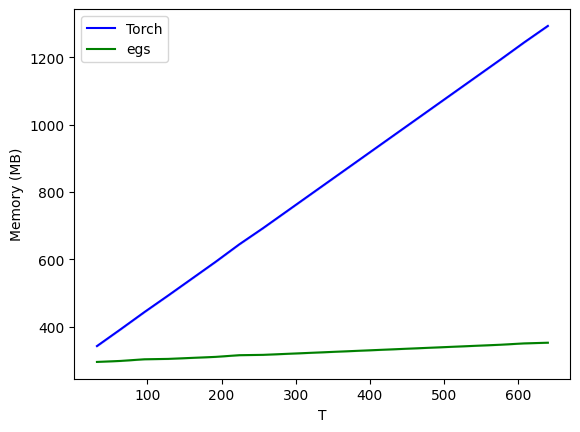

MBs required to complete a forward and a backward pass:
        T        Torch         egs
0    32.0   342.875977  295.875977
1    64.0   392.875977  298.875977
2    96.0   443.750977  303.750977
3   128.0   492.875977  304.875977
4   160.0   542.875977  307.875977
5   192.0   592.875977  310.875977
6   224.0   644.875977  315.875977
7   256.0   692.875977  316.875977
8   288.0   742.875977  319.875977
9   320.0   792.875977  322.875977
10  352.0   842.875977  325.875977
11  384.0   892.875977  328.875977
12  416.0   942.875977  331.875977
13  448.0   992.875977  334.875977
14  480.0  1042.875977  337.875977
15  512.0  1092.875977  340.875977
16  544.0  1142.875977  343.875977
17  576.0  1192.875977  346.875977
18  608.0  1243.875977  350.875977
19  640.0  1292.875977  352.875977


In [11]:

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Memory (MB)",
        plot_name="MBs required to complete a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with E 

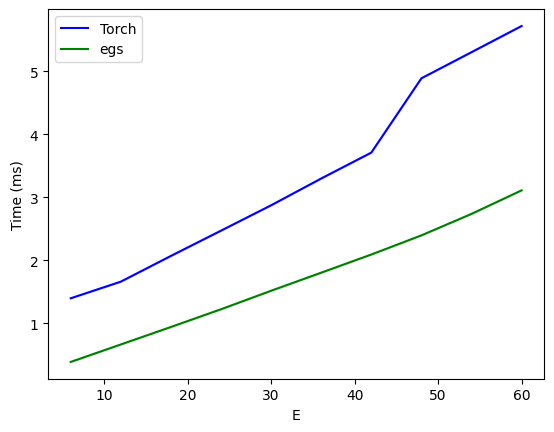

time needed for a forward and a backward pass:
      E     Torch       egs
0   6.0  1.396736  0.386048
1  12.0  1.660928  0.663584
2  18.0  2.069504  0.941056
3  24.0  2.470912  1.222656
4  30.0  2.873344  1.516544
5  36.0  3.299328  1.803888
6  42.0  3.710976  2.092032
7  48.0  4.890624  2.396160
8  54.0  5.305344  2.737312
9  60.0  5.721088  3.111056


In [12]:


configs = [
    triton.testing.Benchmark(
        x_names=["E"],
        x_vals=[6 * (i+1) for i in range(10)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B,"J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

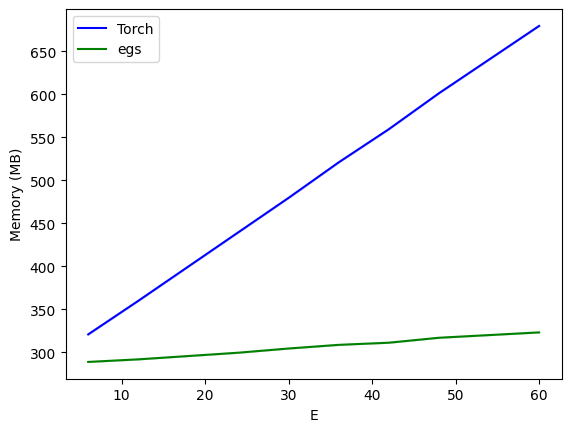

MBs required to complete a forward and a backward pass:
      E       Torch         egs
0   6.0  320.993164  288.993164
1  12.0  359.985352  291.985352
2  18.0  399.852539  295.852539
3  24.0  439.719727  299.719727
4  30.0  479.586914  304.586914
5  36.0  520.829102  308.829102
6  42.0  559.321289  311.321289
7  48.0  601.063477  317.063477
8  54.0  640.180664  320.180664
9  60.0  679.297852  323.297852


In [13]:
configs = [
    triton.testing.Benchmark(
        x_names=["E"],
        x_vals=[6 * (i+1) for i in range(10)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Memory (MB)",
        plot_name="MBs required to complete a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B,"J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with B

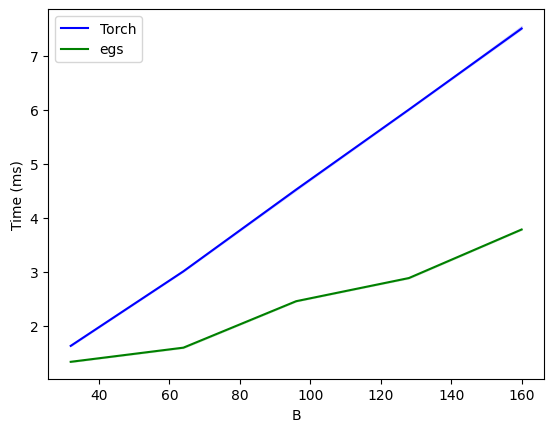

time needed for a forward and a backward pass:
       B     Torch       egs
0   32.0  1.633280  1.338368
1   64.0  3.013600  1.600512
2   96.0  4.525344  2.460160
3  128.0  6.006560  2.888704
4  160.0  7.506432  3.787264


In [ ]:

configs = [
    triton.testing.Benchmark(
        x_names=["B"],
        x_vals=[32 * (i+1) for i in range(5)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "E":E, "J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

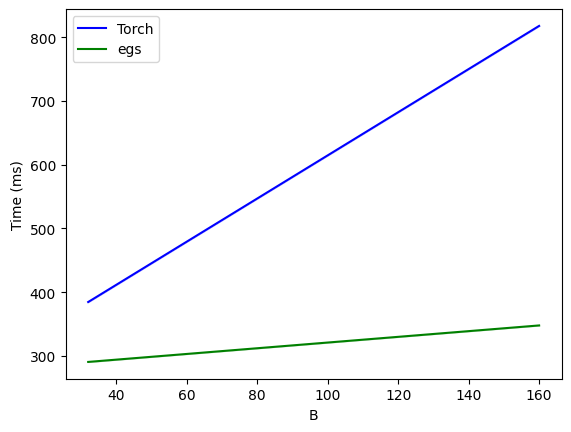

time needed for a forward and a backward pass:
       B       Torch         egs
0   32.0  384.563477  290.563477
1   64.0  492.875977  304.875977
2   96.0  601.188477  319.188477
3  128.0  709.500977  333.500977
4  160.0  817.813477  347.813477


In [23]:
configs = [
    triton.testing.Benchmark(
        x_names=["B"],
        x_vals=[32 * (i+1) for i in range(5)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "E":E, "J": J, "I": I, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scaling with I

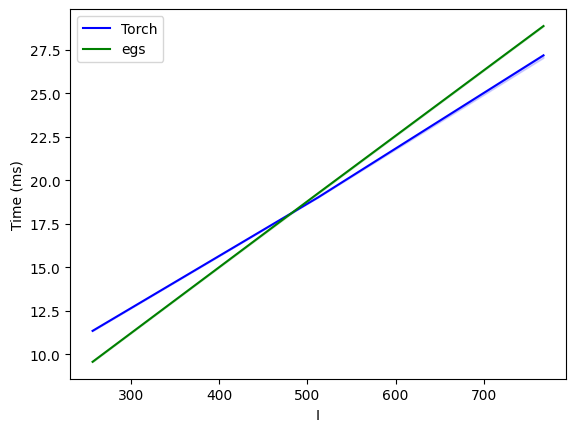

time needed for a forward and a backward pass:
       I      Torch        egs
0  256.0  11.354113   9.577472
1  512.0  19.014656  19.250175
2  768.0  27.171841  28.853249


In [24]:
E = 16
T = 128
K = 32
B = 64
J = 512
I = 64

configs = [
    triton.testing.Benchmark(
        x_names=["I"],
        x_vals=[256 * (i+1) for i in range(3)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E":E, "J": J, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

In [17]:
# Increasing I increases the benefits of the better optimised matrix multiplication, so the sparsity has to be higher in order to observe benefits

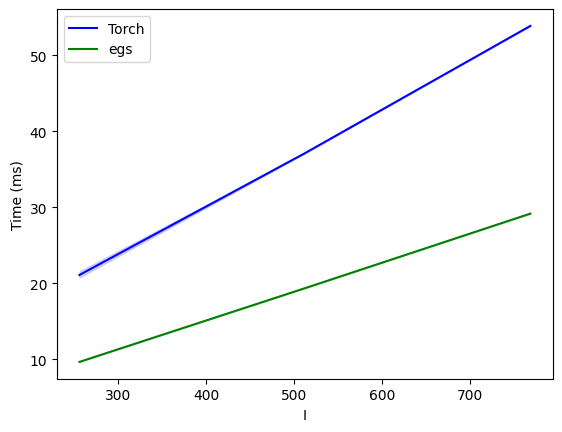

time needed for a forward and a backward pass:
       I      Torch        egs
0  256.0  21.095936   9.660416
1  512.0  37.122559  19.357183
2  768.0  53.870590  29.170689


In [18]:
E = 16
T = 256
K = 32
B = 64
J = 512
I = 64

configs = [
    triton.testing.Benchmark(
        x_names=["I"],
        x_vals=[256 * (i+1) for i in range(3)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E":E, "J": J, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_speed).run(show_plots=True, print_data=True)

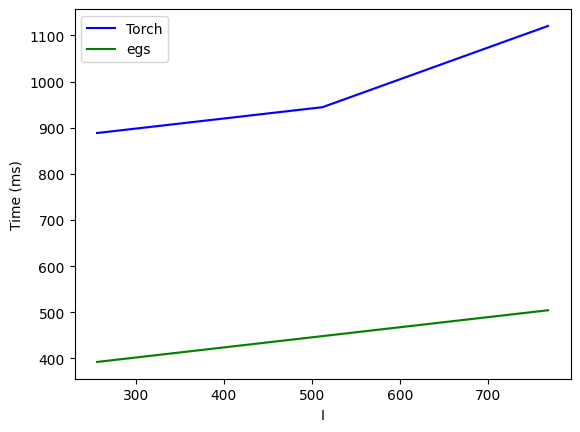

time needed for a forward and a backward pass:
       I        Torch         egs
0  256.0   888.563477  392.563477
1  512.0   944.563477  448.563477
2  768.0  1120.563477  504.563477


In [25]:
configs = [
    triton.testing.Benchmark(
        x_names=["I"],
        x_vals=[256 * (i+1) for i in range(3)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E":E, "J": J, "K": K, "T": T
            },
    )
]
triton.testing.perf_report(configs)(gather_benchmark_memory).run(show_plots=True, print_data=True)

# Scatter

Scatter profiling for compound forward and backward is essentially identical to gather, because forward operations from gather correspond to backward operations from scatter and vice versa. Specifically 
 - Y=Gather(X) corresponds to X_grad=scatter_gradX(Y_grad)
 - X=Scatter(Y) corresponds to Y_grad=gather_gradY(X_grad)
 - scatter_gradW corresponds to gather_gradW

For more details check out the implementations of each function in egs.triton_kernels

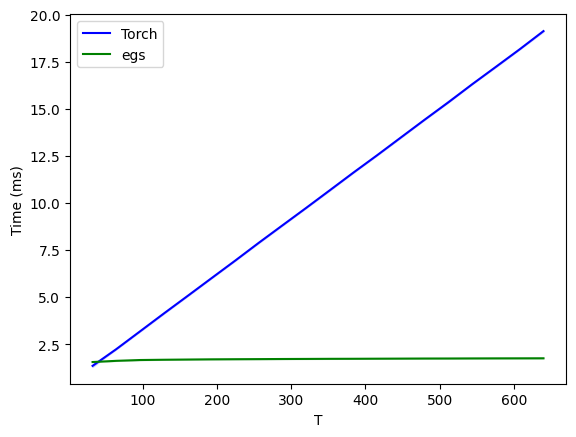

time needed for a forward and a backward pass:
        T      Torch       egs
0    32.0   1.343488  1.546240
1    64.0   2.231296  1.609728
2    96.0   3.174912  1.652736
3   128.0   4.120576  1.667072
4   160.0   5.051360  1.678432
5   192.0   5.988352  1.689600
6   224.0   6.922240  1.695744
7   256.0   7.874560  1.700864
8   288.0   8.804352  1.707008
9   320.0   9.731072  1.711104
10  352.0  10.671104  1.716224
11  384.0  11.614720  1.718784
12  416.0  12.536832  1.723392
13  448.0  13.479936  1.727488
14  480.0  14.422016  1.732112
15  512.0  15.346064  1.733632
16  544.0  16.302080  1.737728
17  576.0  17.227615  1.740800
18  608.0  18.157568  1.742848
19  640.0  19.121153  1.745056


In [26]:
E = 32 # Number of experts
T = 128 # Sequence length
K = 32 # Number of tokens to process by each expert
B = 64 # Batch size
J = 64 # Number of dimensions for the output of gather and input of scatter
I = 128 # Number of dimensions for the input of gather and output of scatter

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(scatter_benchmark_speed).run(show_plots=True, print_data=True)

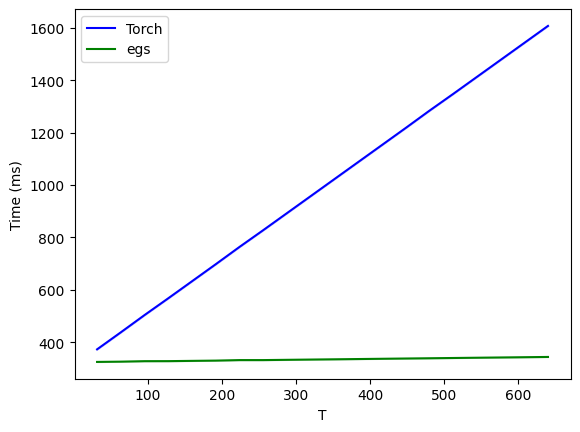

time needed for a forward and a backward pass:
        T        Torch         egs
0    32.0   372.875977  324.875977
1    64.0   437.875977  325.875977
2    96.0   503.750977  327.750977
3   128.0   567.875977  327.875977
4   160.0   632.875977  328.875977
5   192.0   697.875977  329.875977
6   224.0   763.875977  331.875977
7   256.0   827.875977  331.875977
8   288.0   892.875977  332.875977
9   320.0   957.875977  333.875977
10  352.0  1022.875977  334.875977
11  384.0  1087.875977  335.875977
12  416.0  1152.875977  336.875977
13  448.0  1217.875977  337.875977
14  480.0  1283.875977  338.875977
15  512.0  1347.875977  339.875977
16  544.0  1412.875977  340.875977
17  576.0  1477.875977  341.875977
18  608.0  1542.875977  342.875977
19  640.0  1607.875977  343.875977


In [27]:

configs = [
    triton.testing.Benchmark(
        x_names=["T"],
        x_vals=[32 * i + 32 for i in range(20)],
        line_arg="provider",
        line_vals=["torch", "egs"],
        line_names=["Torch", "egs"],
        styles=[ ("blue", "-"), ("green", "-")],
        ylabel="Time (ms)",
        plot_name="time needed for a forward and a backward pass",
        args={
            "fp8_inputs": False,
            "B": B, "E": E, "J": J, "I": I, "K": K
            },
    )
]
triton.testing.perf_report(configs)(scatter_benchmark_memory).run(show_plots=True, print_data=True)